<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>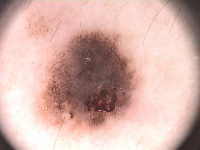</td><td>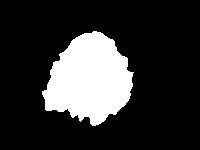</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [5]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=dcee8f0a-5383-49ae-b3f8-1287a06551e3
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 118MB/s]


In [6]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [7]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [8]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [9]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

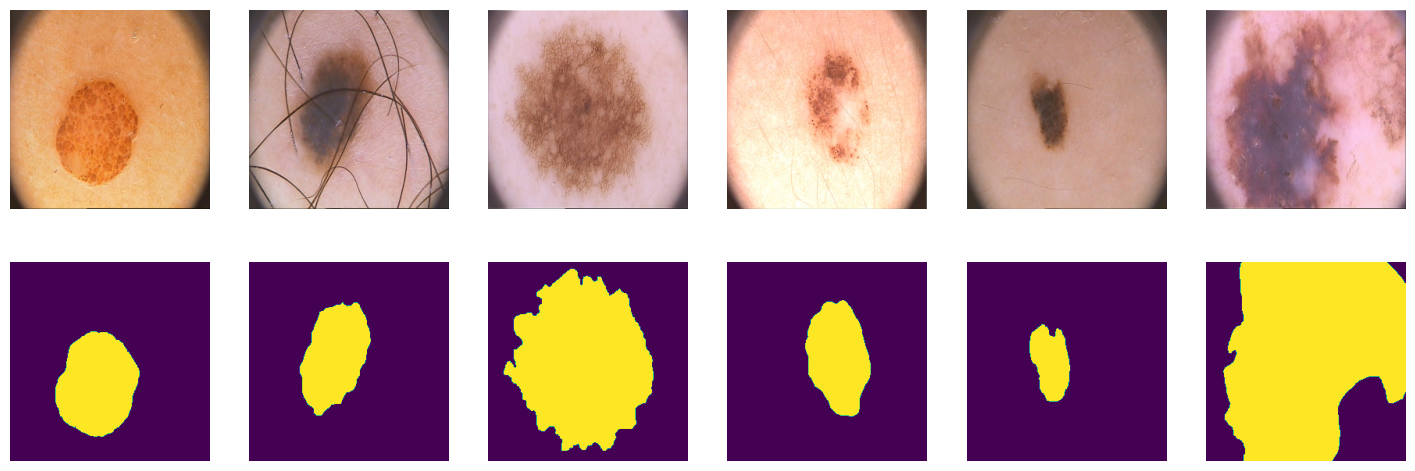

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [11]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [12]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [13]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [14]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [15]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 19.0 MB/s eta 0:00:00


In [16]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**
For brevity, let x = logits, z = labels. The logistic loss is
$$\mathcal \
\text{Logistic Loss} = z \cdot \left(-\log(\sigma(x))\right) + (1 - z) \cdot \left(-\log(1 - \sigma(x))\right)
$$

$$\mathcal
= z \cdot \left(-\log\left(\frac{1}{1 + e^{-x}}\right)\right) + (1 - z) \cdot \left(-\log\left(\frac{e^{-x}}{1 + e^{-x}}\right)\right)
\
$$

$$\mathcal
= z \cdot \log(1 + e^{-x}) + (1 - z) \cdot \left(-\log(e^{-x}) + \log(1 + e^{-x})\right)
\
$$

$$\mathcal
= z \cdot \log(1 + e^{-x}) + (1 - z) \cdot \left(x + \log(1 + e^{-x})\right)
\
$$
$$\mathcal
= x - x \cdot z + \log(1 + e^{-x})
\
$$

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [17]:
import torch.nn.functional as F
import torch.nn as nn

In [18]:
bce_torch = nn.BCELoss(reduction='sum')
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [19]:
def bce_loss(y_pred, y_real):
  loss = y_pred - y_pred * y_real + np.log(1 + np.exp(-y_pred))
  return loss.sum()

def bce_true(y_pred, y_real):
  log_sigm = nn.LogSigmoid()
  sigm = nn.Sigmoid()
  loss = -y_real * log_sigm(y_pred) - (1 - y_real) * np.log(1 - sigm(y_pred))
  return loss.sum()

Проверим корректность работы на простом примере

In [20]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 7.111527442932129
BCE loss честно посчитанный = 7.111527919769287
BCE loss from torch bce_torch = 7.111527442932129
BCE loss from torch with logits bce_torch = 7.111527919769287


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [21]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [22]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 13.301284790039062
BCE loss честно посчитанный = 13.301283836364746
BCE loss from torch bce_torch = 13.301283836364746
BCE loss from torch with logits bce_torch = 13.301284790039062


In [24]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [25]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 4.78MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 3.62MB/s]
Download completed


In [26]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

<ipython-input-26-cd9dbfff2c1b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
<ipython-input-

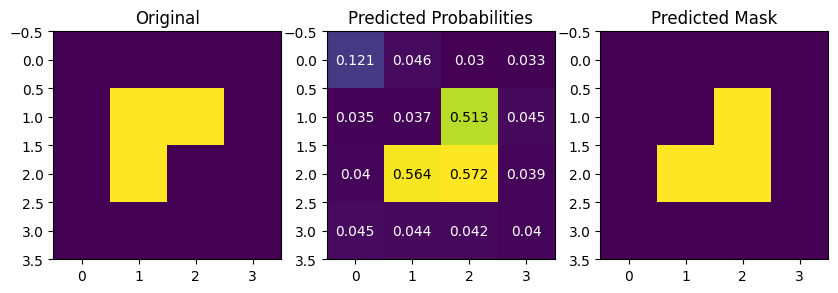

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [28]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

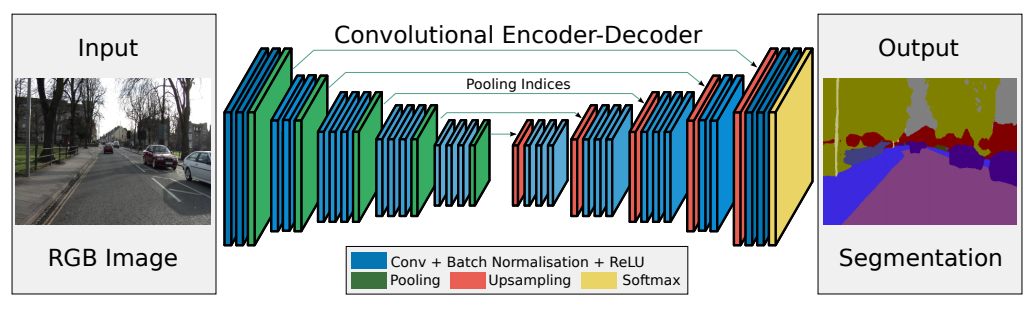

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [30]:
class ConvReLU(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1) -> None:
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvReLU(in_c if i == 0 else out_c, out_c, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, ind = self.pool(x)
        return x, ind

class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1, classification=False) -> None:
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvReLU(in_c, out_c, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvReLU(in_c, in_c, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind):
        x = self.unpool(x, ind)
        for layer in self.layers:
            x = layer(x)
        return x

class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=64) -> None:
        super(SegNet, self).__init__()

        # encoder
        self.enc0 = EncoderBlock(in_channels, features)
        self.enc1 = EncoderBlock(features, features * 2)
        self.enc2 = EncoderBlock(features * 2, features * 4, depth=3)
        self.enc3 = EncoderBlock(features * 4, features * 8, depth=3)

        # bottleneck
        self.bottleneck_enc = EncoderBlock(features * 8, features * 8, depth=3)
        self.bottleneck_dec = DecoderBlock(features * 8, features * 8, depth=3)

        # decoder
        self.dec0 = DecoderBlock(features * 8, features * 4, depth=3)
        self.dec1 = DecoderBlock(features * 4, features * 2, depth=3)
        self.dec2 = DecoderBlock(features * 2, features)
        self.dec3 = DecoderBlock(features, out_channels, classification=True)

    def forward(self, x):
        # encoder
        e0, ind0 = self.enc0(x)
        e1, ind1 = self.enc1(e0)
        e2, ind2 = self.enc2(e1)
        e3, ind3 = self.enc3(e2)

        # bottleneck
        b0, indb = self.bottleneck_enc(e3)
        b1 = self.bottleneck_dec(b0, indb)

        # decoder
        d0 = self.dec0(b1, ind3)
        d1 = self.dec1(d0, ind2)
        d2 = self.dec2(d1, ind1)

        # classification layer
        output = self.dec3(d2, ind0)
        return output

In [31]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [32]:
from tqdm.notebook import tqdm

In [33]:
def train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, num_epochs, device):
    losses_train = []
    losses_val = []
    for epoch in range(num_epochs):
        model.train()
        running_loss_train = 0.0
        for images, masks in tqdm(train_dataloader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item()
        train_loss = running_loss_train / len(train_dataloader)

        model.eval()
        running_loss_val = 0.0
        with torch.no_grad():
            for images, masks in valid_dataloader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, masks)
                running_loss_val += loss.item()

        val_loss = running_loss_val / len(valid_dataloader)
        losses_train.append(train_loss)
        losses_val.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return losses_train, losses_val

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [34]:
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss()

train(segnet_model, train_dataloader, valid_dataloader, optimizer, loss_fn, num_epochs=10, device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.6659, Validation Loss: 0.6877


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.6171, Validation Loss: 0.6805


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.5323, Validation Loss: 0.6668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.4530, Validation Loss: 0.6473


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 0.3944, Validation Loss: 0.6415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.3494, Validation Loss: 0.6717


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.3208, Validation Loss: 0.7232


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.2792, Validation Loss: 0.7692


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.2481, Validation Loss: 0.5576


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.2245, Validation Loss: 0.3797


([0.6658537685871124,
  0.6170945465564728,
  0.5323116928339005,
  0.4529842138290405,
  0.3943559229373932,
  0.3493984490633011,
  0.3207979053258896,
  0.27923955768346786,
  0.24806004017591476,
  0.22454135492444038],
 [0.6877358853816986,
  0.6804612874984741,
  0.6667687892913818,
  0.6473425626754761,
  0.641457736492157,
  0.6716524958610535,
  0.7231751978397369,
  0.7692263722419739,
  0.5575846135616302,
  0.3797309845685959])

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [35]:
def test(model, test_dataloader, device, iou):
  model.eval()
  iou.reset()
  iou_scores = []
  with torch.no_grad():
    for images, masks in tqdm(test_dataloader):
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
      predicted_masks = (outputs > 0.5).float()
      iou_score = iou(predicted_masks, masks)
      iou_scores.append(iou_score.item())

  mean_iou_score = sum(iou_scores) / len(iou_scores)
  print(f"Mean IoU Score: {mean_iou_score:.3f}")
  return mean_iou_score

In [36]:
test_score = test(segnet_model, test_dataloader, device, iou_score)

  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.397


# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [37]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''

    eps = 1e-8
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()

    TP = (preds * labels).sum(dim=(1,2,3))
    FP = (preds * (1 - labels)).sum(dim=(1,2,3))
    FN = ((1 - preds) * labels).sum(dim=(1, 2, 3))

    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)
    return dice

Проверим на корректность функцию dice_score:

In [38]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [39]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [40]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''

    eps: float = 1e-8
    probs = torch.sigmoid(logits)

    TP = (probs * labels).sum(dim=(1,2,3))
    FP = (probs * (1 - labels)).sum(dim=(1,2,3))
    FN = ((1 - probs) * labels).sum(dim=(1, 2, 3))

    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)
    loss = 1 - dice

    return loss.sum()

Проверка на корректность:

In [41]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=508a21d28d42869dff70063997fec2fc680ef946778e502f4df33579de95424e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=926c53b8b4f380a882573e67bec782fcc38cae62591a1e4b982fce4a91177ab8
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [42]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [43]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [44]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    sigm = torch.sigmoid(y_pred)
    pt = sigm * y_real + (1 - sigm) * (1 - y_real)
    focal_weight = (1 - pt) ** gamma
    loss = -focal_weight * (y_real * torch.log(sigm + eps) + (1 - y_real) * torch.log(1 - sigm + eps))
    return loss.sum()

Проверка корректности функции:

In [45]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [46]:
focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2.0)

tensor(3.6161, device='cuda:0')

In [47]:
assert np.isclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum').cpu().item(), focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2.0).cpu().item())

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [48]:
def tversky_loss(y_pred, y_real,  alpha=0.3, beta=0.7):
    sigm = torch.sigmoid(y_pred)
    TP = (sigm * y_real).sum()
    FP = ((1-y_real) * sigm).sum()
    FN = (y_real * (1-sigm)).sum()

    return 1 - TP / (TP + alpha*FP + beta*FN )

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.

**Ответ**:

1) Из графиков ниже можно сделать вывод, что наиболее быстро сходится модель с использованием Focal Loss

2) Набольшее значение метрики IoU достигается при использовании Focal Loss: 0.812


In [50]:
max_epochs = 25
bce_loss = nn.BCEWithLogitsLoss()
losses = [bce_loss, dice_loss, focal_loss, tversky_loss]
metric_losses_segnet = []
iou_scores_segnet = []
for loss_fn in losses:
    segnet_model = SegNet().to(device)
    optimizer = torch.optim.Adam(segnet_model.parameters(), lr = 0.0001)
    torch.cuda.empty_cache()
    history = train(segnet_model, train_dataloader, valid_dataloader, optimizer, loss_fn, num_epochs=max_epochs, device=device)
    metric_losses_segnet.append(history)
    model_score = test(segnet_model, test_dataloader, device, iou_score)
    iou_scores_segnet.append(model_score)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/25], Train Loss: 0.6816, Validation Loss: 0.6921


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/25], Train Loss: 0.6009, Validation Loss: 0.6859


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/25], Train Loss: 0.5086, Validation Loss: 0.6746


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/25], Train Loss: 0.4439, Validation Loss: 0.6564


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/25], Train Loss: 0.3797, Validation Loss: 0.6416


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/25], Train Loss: 0.3376, Validation Loss: 0.6443


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/25], Train Loss: 0.3056, Validation Loss: 0.6541


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/25], Train Loss: 0.2694, Validation Loss: 0.5946


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/25], Train Loss: 0.2638, Validation Loss: 0.5204


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/25], Train Loss: 0.2384, Validation Loss: 0.4215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/25], Train Loss: 0.2492, Validation Loss: 0.3287


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/25], Train Loss: 0.1993, Validation Loss: 0.2536


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/25], Train Loss: 0.1837, Validation Loss: 0.2407


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/25], Train Loss: 0.1787, Validation Loss: 0.2122


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/25], Train Loss: 0.1685, Validation Loss: 0.2067


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/25], Train Loss: 0.1660, Validation Loss: 0.2105


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/25], Train Loss: 0.1408, Validation Loss: 0.2031


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/25], Train Loss: 0.1345, Validation Loss: 0.1983


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/25], Train Loss: 0.1270, Validation Loss: 0.1962


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/25], Train Loss: 0.1243, Validation Loss: 0.1874


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/25], Train Loss: 0.1580, Validation Loss: 0.1880


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/25], Train Loss: 0.1456, Validation Loss: 0.1766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/25], Train Loss: 0.1877, Validation Loss: 0.1752


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/25], Train Loss: 0.1311, Validation Loss: 0.1421


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/25], Train Loss: 0.1178, Validation Loss: 0.1406


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.798


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/25], Train Loss: 15.1641, Validation Loss: 15.8417


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/25], Train Loss: 13.2926, Validation Loss: 15.8731


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/25], Train Loss: 12.0777, Validation Loss: 15.9818


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/25], Train Loss: 11.1358, Validation Loss: 16.1749


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/25], Train Loss: 10.5346, Validation Loss: 16.4901


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/25], Train Loss: 9.9008, Validation Loss: 16.8773


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/25], Train Loss: 9.6736, Validation Loss: 17.3882


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/25], Train Loss: 8.9874, Validation Loss: 16.0911


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/25], Train Loss: 8.7095, Validation Loss: 14.5054


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/25], Train Loss: 8.3475, Validation Loss: 12.9586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/25], Train Loss: 8.1512, Validation Loss: 9.1249


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/25], Train Loss: 8.0800, Validation Loss: 8.6807


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/25], Train Loss: 7.7040, Validation Loss: 7.2227


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/25], Train Loss: 7.2987, Validation Loss: 6.9039


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/25], Train Loss: 7.0100, Validation Loss: 6.7210


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/25], Train Loss: 6.8187, Validation Loss: 6.4443


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/25], Train Loss: 6.4912, Validation Loss: 6.1846


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/25], Train Loss: 6.2052, Validation Loss: 6.2569


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/25], Train Loss: 5.9493, Validation Loss: 5.7357


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/25], Train Loss: 5.7965, Validation Loss: 5.6794


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/25], Train Loss: 5.5119, Validation Loss: 5.7327


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/25], Train Loss: 5.1256, Validation Loss: 5.6290


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/25], Train Loss: 4.8623, Validation Loss: 5.5528


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/25], Train Loss: 4.7796, Validation Loss: 5.8917


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/25], Train Loss: 4.5327, Validation Loss: 5.4369


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.805


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/25], Train Loss: 288253.5859, Validation Loss: 280024.7969


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/25], Train Loss: 199199.5547, Validation Loss: 276050.7500


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/25], Train Loss: 142362.8203, Validation Loss: 268109.0703


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/25], Train Loss: 118026.1055, Validation Loss: 263966.3281


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/25], Train Loss: 98699.4453, Validation Loss: 278514.4531


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/25], Train Loss: 84228.0723, Validation Loss: 325352.3438


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/25], Train Loss: 82729.4121, Validation Loss: 406883.0625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/25], Train Loss: 72975.7607, Validation Loss: 508794.2969


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/25], Train Loss: 66184.6201, Validation Loss: 508789.8281


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/25], Train Loss: 65618.9785, Validation Loss: 406000.1562


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/25], Train Loss: 57312.4785, Validation Loss: 213986.9844


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/25], Train Loss: 67512.6113, Validation Loss: 226568.2109


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/25], Train Loss: 52262.8438, Validation Loss: 137825.1328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/25], Train Loss: 45164.0381, Validation Loss: 105913.9180


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/25], Train Loss: 64121.0723, Validation Loss: 114846.7773


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/25], Train Loss: 51934.8184, Validation Loss: 78960.9492


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/25], Train Loss: 37560.3135, Validation Loss: 71366.4785


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/25], Train Loss: 35347.7046, Validation Loss: 62025.2969


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/25], Train Loss: 33861.2798, Validation Loss: 61537.9121


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/25], Train Loss: 34150.0684, Validation Loss: 67250.6836


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/25], Train Loss: 32284.0630, Validation Loss: 60842.9570


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/25], Train Loss: 30934.4937, Validation Loss: 65990.7266


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/25], Train Loss: 27593.8145, Validation Loss: 65358.2617


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/25], Train Loss: 34717.8364, Validation Loss: 71136.3594


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/25], Train Loss: 34463.2622, Validation Loss: 126109.2695


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.812


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/25], Train Loss: 0.5316, Validation Loss: 0.5689


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/25], Train Loss: 0.4453, Validation Loss: 0.5735


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/25], Train Loss: 0.3791, Validation Loss: 0.5833


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/25], Train Loss: 0.3296, Validation Loss: 0.5978


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/25], Train Loss: 0.3022, Validation Loss: 0.6197


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/25], Train Loss: 0.2642, Validation Loss: 0.6463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/25], Train Loss: 0.2477, Validation Loss: 0.6741


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/25], Train Loss: 0.2290, Validation Loss: 0.6481


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/25], Train Loss: 0.2167, Validation Loss: 0.5063


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/25], Train Loss: 0.2067, Validation Loss: 0.3883


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/25], Train Loss: 0.1878, Validation Loss: 0.2627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/25], Train Loss: 0.1859, Validation Loss: 0.2349


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/25], Train Loss: 0.1733, Validation Loss: 0.2119


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/25], Train Loss: 0.1615, Validation Loss: 0.1935


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/25], Train Loss: 0.1806, Validation Loss: 0.1573


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/25], Train Loss: 0.1562, Validation Loss: 0.1682


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/25], Train Loss: 0.1434, Validation Loss: 0.1705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/25], Train Loss: 0.1383, Validation Loss: 0.1545


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/25], Train Loss: 0.1481, Validation Loss: 0.1556


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/25], Train Loss: 0.1327, Validation Loss: 0.1538


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/25], Train Loss: 0.1319, Validation Loss: 0.1397


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/25], Train Loss: 0.1170, Validation Loss: 0.1367


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/25], Train Loss: 0.1169, Validation Loss: 0.1246


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/25], Train Loss: 0.1077, Validation Loss: 0.1213


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/25], Train Loss: 0.1096, Validation Loss: 0.1260


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.785


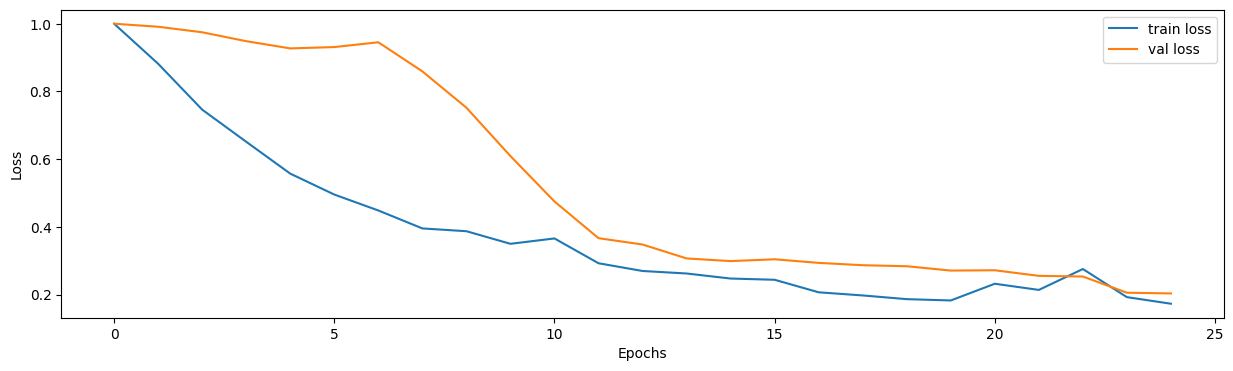

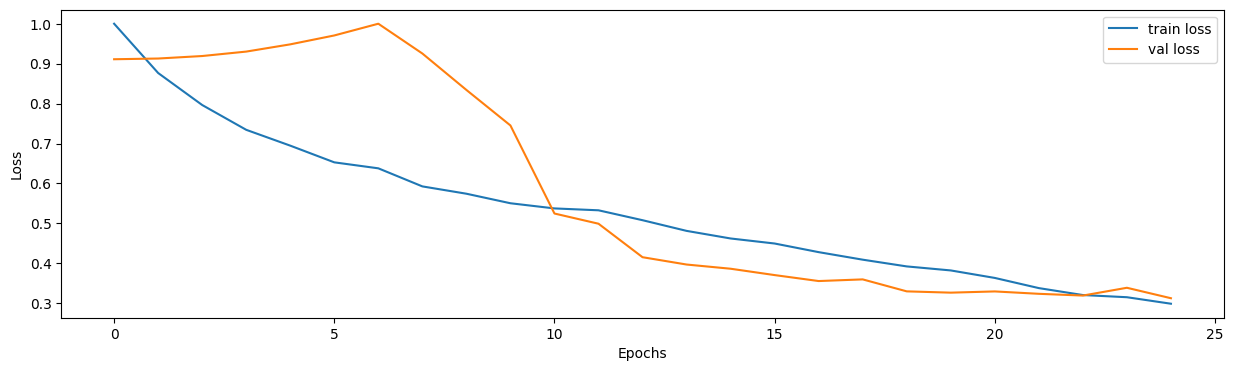

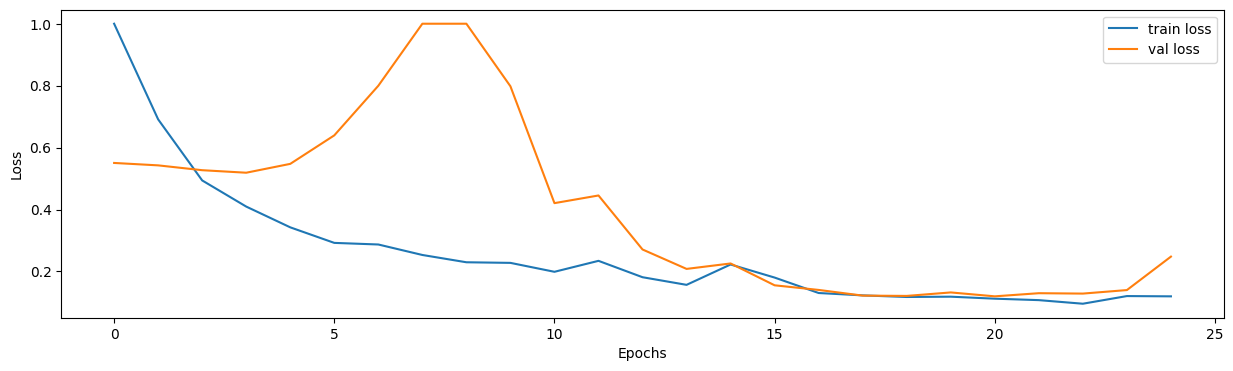

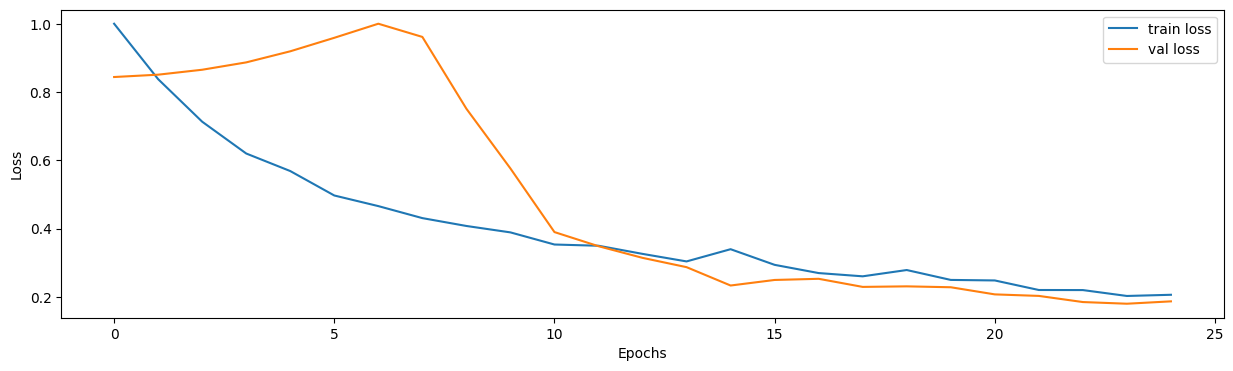

In [85]:
for losses in metric_losses_segnet:
    plt.plot([x/max(losses[0]) for x in losses[0]])
    plt.plot([x/max(losses[1]) for x in losses[1]])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['train loss','val loss'])
    plt.show()

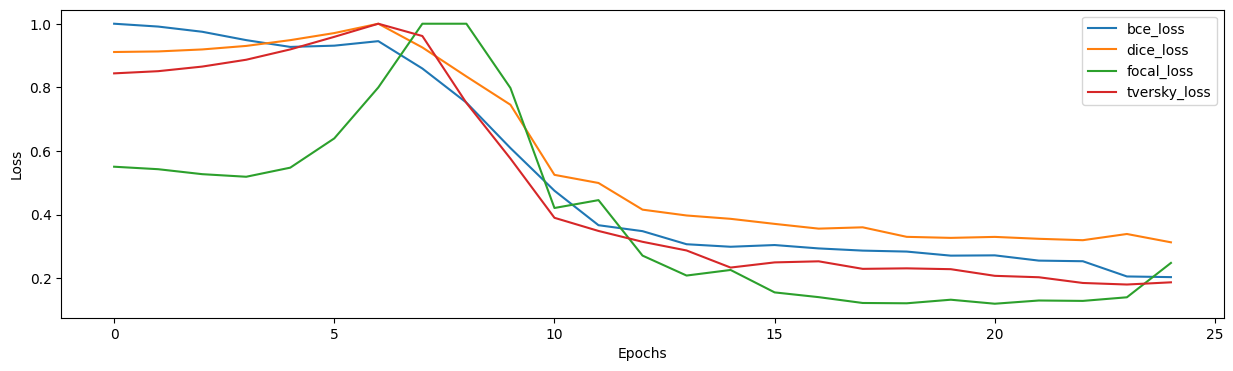

In [66]:
for losses in metric_losses_segnet:
    plt.plot([x/max(losses[1]) for x in losses[1]])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['bce_loss', 'dice_loss', 'focal_loss', 'tversky_loss'])

In [84]:
iou_scores_segnet

[0.7978000640869141, 0.8050391376018524, 0.811873733997345, 0.7852708697319031]

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

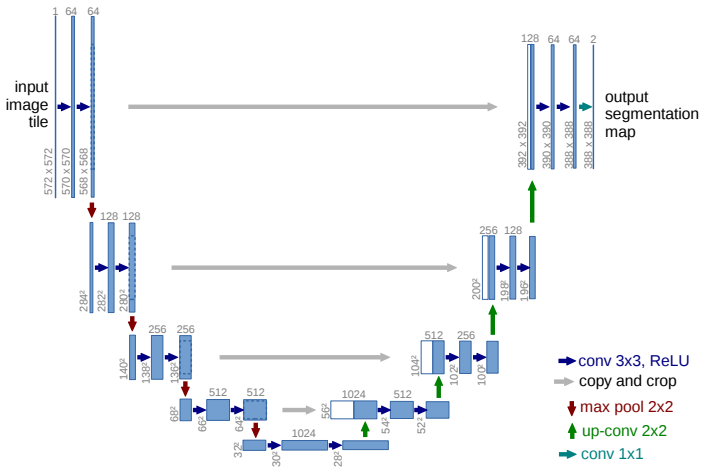

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [54]:
import torch.nn.functional as F
import torch.nn as nn

In [55]:
class ConvMod(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvMod(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = ConvMod(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = ConvMod(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [56]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.

**Ответ:**

1) Наибольшее значение метрики IoU достигается при использовании BCE: 0.784

2) Наименьшее значение лосса достигается при использовании Focal Loss

3) Модель с Dice Loss практически перестает обучаться после 5 эпохи, следовательно данная модель обучается быстрее остальных

4) Из полученных результатов следует, что наилучшие результаты достигаются при использовании архитектуры SegNet c Focal Loss



In [57]:
max_epochs = 25
bce_loss = nn.BCEWithLogitsLoss()
losses = [bce_loss, dice_loss, focal_loss]
metric_losses_unet = []
iou_scores_unet = []
for loss_fn in losses:
    unet_model = UNet().to(device)
    optimizer = torch.optim.Adam(unet_model.parameters(), lr = 0.0001)
    torch.cuda.empty_cache()
    history = train(unet_model, train_dataloader, valid_dataloader, optimizer, loss_fn, num_epochs=max_epochs, device=device)
    metric_losses_unet.append(history)
    model_score = test(segnet_model, test_dataloader, device, iou_score)
    iou_scores_unet.append(model_score)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/25], Train Loss: 0.7074, Validation Loss: 0.7024


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/25], Train Loss: 0.6998, Validation Loss: 0.6950


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/25], Train Loss: 0.6925, Validation Loss: 0.6849


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/25], Train Loss: 0.6800, Validation Loss: 0.6691


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/25], Train Loss: 0.6616, Validation Loss: 0.6374


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/25], Train Loss: 0.6217, Validation Loss: 0.5938


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/25], Train Loss: 0.5997, Validation Loss: 0.5820


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/25], Train Loss: 0.5880, Validation Loss: 0.5729


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/25], Train Loss: 0.5791, Validation Loss: 0.5634


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/25], Train Loss: 0.5701, Validation Loss: 0.5518


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/25], Train Loss: 0.5578, Validation Loss: 0.5334


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/25], Train Loss: 0.5384, Validation Loss: 0.5054


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/25], Train Loss: 0.5109, Validation Loss: 0.4773


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/25], Train Loss: 0.4947, Validation Loss: 0.4462


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/25], Train Loss: 0.4667, Validation Loss: 0.4522


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/25], Train Loss: 0.4637, Validation Loss: 0.4204


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/25], Train Loss: 0.4410, Validation Loss: 0.5037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/25], Train Loss: 0.4888, Validation Loss: 0.4163


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/25], Train Loss: 0.4690, Validation Loss: 0.4360


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/25], Train Loss: 0.4398, Validation Loss: 0.4215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/25], Train Loss: 0.4395, Validation Loss: 0.4013


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/25], Train Loss: 0.4210, Validation Loss: 0.3851


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/25], Train Loss: 0.4054, Validation Loss: 0.3636


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/25], Train Loss: 0.3953, Validation Loss: 0.4772


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/25], Train Loss: 0.4376, Validation Loss: 0.4457


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.784


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/25], Train Loss: 16.1176, Validation Loss: 15.9239


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/25], Train Loss: 16.0644, Validation Loss: 15.8628


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/25], Train Loss: 15.9944, Validation Loss: 15.7809


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/25], Train Loss: 15.8980, Validation Loss: 15.6445


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/25], Train Loss: 15.6878, Validation Loss: 15.0699


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/25], Train Loss: 14.2466, Validation Loss: 13.3549


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/25], Train Loss: 13.5874, Validation Loss: 13.3855


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/25], Train Loss: 13.5979, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/25], Train Loss: 13.8345, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/25], Train Loss: 13.5980, Validation Loss: 13.3857


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.783


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/25], Train Loss: 272421.4531, Validation Loss: 269327.8125


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/25], Train Loss: 267599.3516, Validation Loss: 264793.8594


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/25], Train Loss: 263378.8906, Validation Loss: 259196.8672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/25], Train Loss: 258201.3398, Validation Loss: 253136.4688


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/25], Train Loss: 252584.4180, Validation Loss: 246583.6328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/25], Train Loss: 246486.6875, Validation Loss: 241099.1094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/25], Train Loss: 242875.3594, Validation Loss: 235236.6172


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/25], Train Loss: 236875.8984, Validation Loss: 227555.3516


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/25], Train Loss: 225228.8086, Validation Loss: 208708.7188


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/25], Train Loss: 213606.2266, Validation Loss: 193974.7031


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/25], Train Loss: 201131.0781, Validation Loss: 185446.3828


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/25], Train Loss: 198610.6211, Validation Loss: 182228.8594


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/25], Train Loss: 196445.4453, Validation Loss: 174299.6719


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/25], Train Loss: 186532.7930, Validation Loss: 173709.6016


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/25], Train Loss: 186655.1250, Validation Loss: 172986.4141


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/25], Train Loss: 181836.7891, Validation Loss: 172664.0469


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/25], Train Loss: 189597.9844, Validation Loss: 182051.1328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/25], Train Loss: 189417.7188, Validation Loss: 163244.8281


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/25], Train Loss: 175734.6875, Validation Loss: 164270.2812


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/25], Train Loss: 169373.6719, Validation Loss: 162294.5625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/25], Train Loss: 167812.1211, Validation Loss: 153805.9570


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/25], Train Loss: 159419.2578, Validation Loss: 142032.1016


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/25], Train Loss: 153101.0039, Validation Loss: 132083.6758


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/25], Train Loss: 138482.7051, Validation Loss: 119168.6367


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/25], Train Loss: 139813.0508, Validation Loss: 123379.4062


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.782


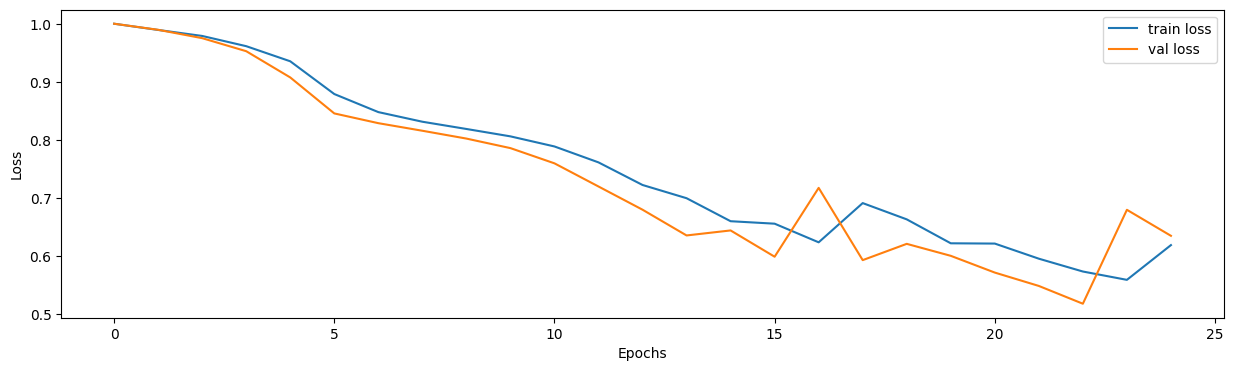

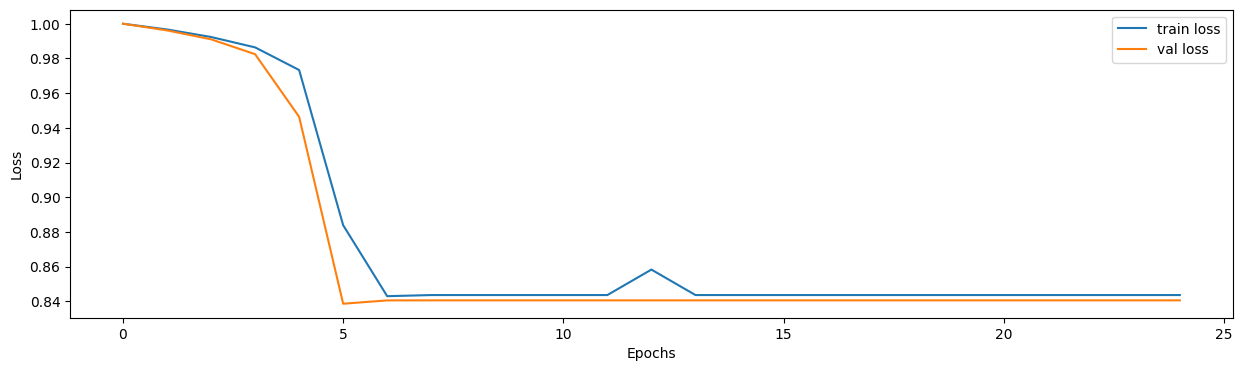

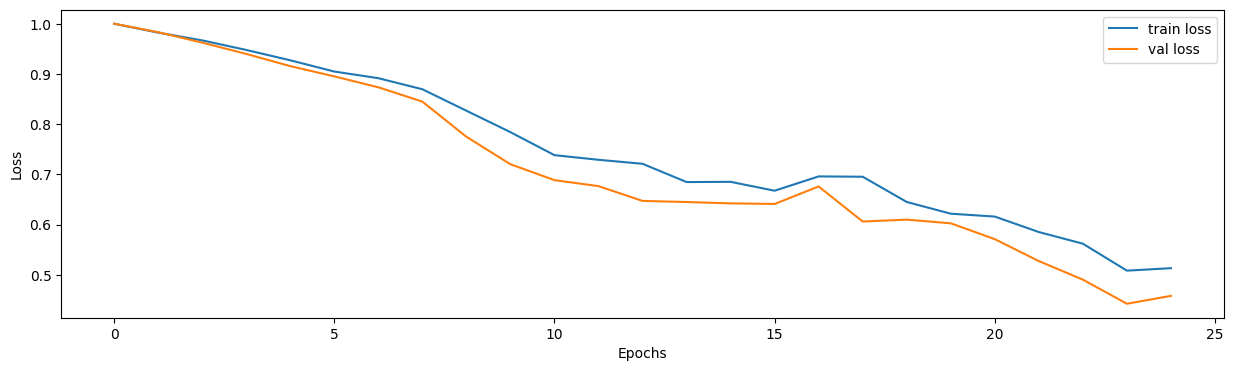

In [86]:
for losses in metric_losses_unet:
    plt.plot([x/max(losses[0]) for x in losses[0]])
    plt.plot([x/max(losses[1]) for x in losses[1]])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['train loss','val loss'])
    plt.show()

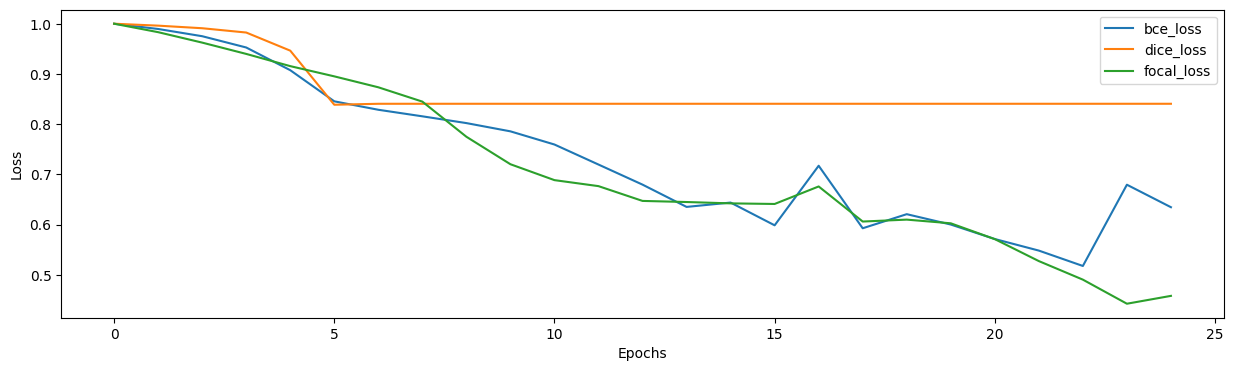

In [68]:
for losses in metric_losses_unet:
    plt.plot([x/max(losses[1]) for x in losses[1]])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['bce_loss', 'dice_loss', 'focal_loss'])

In [71]:
iou_scores_unet

[0.783902645111084, 0.7827752828598022, 0.7820749282836914]

Best SegNet IoU Score = 0.812
Best UNet IoU Score = 0.784


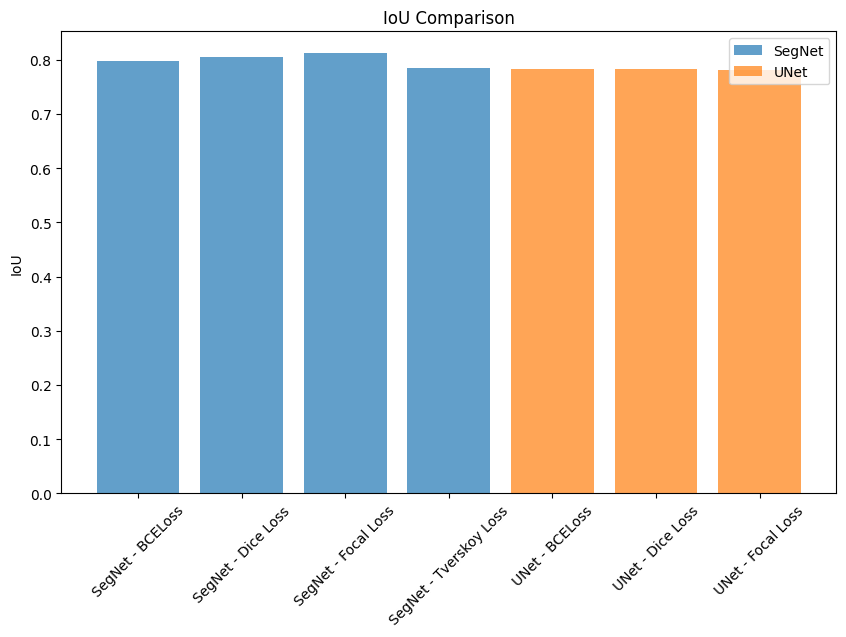

In [91]:
print(f"Best SegNet IoU Score = {max(iou_scores_segnet):.3f}")
print(f"Best UNet IoU Score = {max(iou_scores_unet):.3f}")

losses = ['BCELoss', 'Dice Loss', 'Focal Loss', 'Tverskoy Loss']

plt.figure(figsize=(10, 6))

plt.bar([f'SegNet - {losses[i]}' for i in range(len(iou_scores_segnet))], iou_scores_segnet, label="SegNet", alpha=0.7)
plt.bar([f'UNet - {losses[i]}' for i in range(len(iou_scores_unet))], iou_scores_unet, label="UNet", alpha=0.7)
plt.ylabel("IoU")
plt.title("IoU Comparison")
plt.xticks(rotation=45)
plt.legend()
plt.show()